In [1]:
from fastai.vision.all import *

In [2]:
from polvo.core import *

In [3]:
def get_label(image_file):
    return image_file.parent.name

In [4]:
def open_as_grayscale_3channels(image_file):
    image = PILImage.create(image_file, mode="L")
    image = np.array(image)[..., None]
    image = np.repeat(image, 3, axis=-1)
    return PILImage.create(image)

In [5]:
learn = load_learner('(160, 214).pkl')
learn.cuda();

In [6]:
data_dir = Path.home() / 'data/Projeto Linda Lifetech - Alysson-Lucas/original models'
image_files = get_image_files(data_dir/'set.2313.train_test/test/Suspeito')
len(image_files)

117

In [7]:
test_dl = learn.dls.test_dl(image_files, bs=1)

In [8]:
class Hook:
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [9]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [10]:
cls = 1

xs = []
grads = []
outputs = []
acts = []

layer = -2
with HookBwd(learn.model[0][layer]) as hookg:
    with Hook(learn.model[0][layer]) as hook:
        for x, in test_dl:
            xs.extend(x)
            
            output = learn.model.eval()(x.cuda())
            output[0, cls].backward()
            
#             for out_ in output:
#                 out_[cls].backward(retain_graph=True)
                
            outputs.extend(output)
            
            act = hook.stored
            acts.extend(act)
            
            grad = hookg.stored
            grads.extend(grad)

/home/lgvaz/miniconda3/envs/fastai/lib/python3.7/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [11]:
preds = torch.stack(outputs).argmax(dim=-1)
preds.sum() / len(preds)

TensorBase(0.7009, device='cuda:0')

In [12]:
act[0].shape

torch.Size([256, 14, 14])

In [13]:
learn.model[1][-1].weight.shape

torch.Size([2, 512])

In [17]:
# cam_maps = []
# for act in acts:
#     cam_map = torch.einsum('ck,kij->cij', learn.model[0][layer].weight, act)
#     cam_maps.append(cam_map)

In [18]:
gradcam_maps = []
for act, grad in zip(acts, grads):
    w = grad.mean(dim=[1,2], keepdim=True)
    gradcam_map = (w * act).sum(0)
    gradcam_maps.append(gradcam_map)

In [19]:
shows = []

for i in range(len(xs)):
    def _show(ctx, i=i):
        ax = ctx
        x = xs[i]
#         cam_map = cam_maps[i]
        gradcam_map = gradcam_maps[i]

        x_dec = TensorImage(test_dl.decode((x,))[0][0])
        x_dec.show(ax=ax, cmap='gray')
#         ax.imshow(cam_map[1].detach().cpu(), alpha=0.9, extent=(0,214,214,0), interpolation='bilinear', cmap='coolwarm')
        ax.imshow(gradcam_map.detach().cpu(), alpha=0.9, extent=(0,214,214,0), interpolation='bilinear', cmap='coolwarm')
        
    x = xs[i]
    x_dec = TensorImage(test_dl.decode((x,))[0][0])
    shows.append(partial(x_dec.show, cmap='gray'))
    
    shows.append(_show)

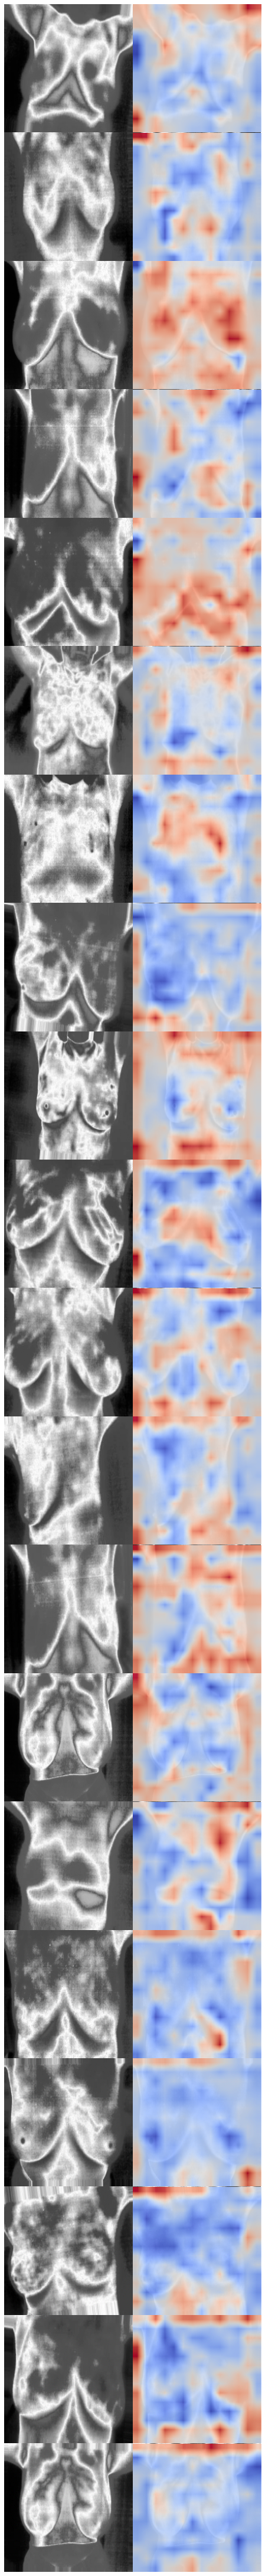

In [20]:
fig, grid = image_grid(shows[:40], ncols=2)

In [ ]:
fig.savefig('suspeito.png')